In [ ]:
import torch.nn as nn  
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from scipy.special import erf

## Функции Активации

## Мотивация:
- Функции активации вводят нелинейность, что позволяет:

    - аппроксимировать любую непрерывную функцию (теорема универсальной аппроксимации);

    - выделять сложные зависимости;

    - управлять динамикой обучения (через градиенты);
- Функция активации должна:

    - быть нелинейной (иначе сеть не будет глубокой);

    - быть дифференцируемой почти везде (для обратного распространения ошибки);

    - не "убивать" градиенты (иначе возникает проблема vanishing gradient);

    - быть вычислительно простой;
    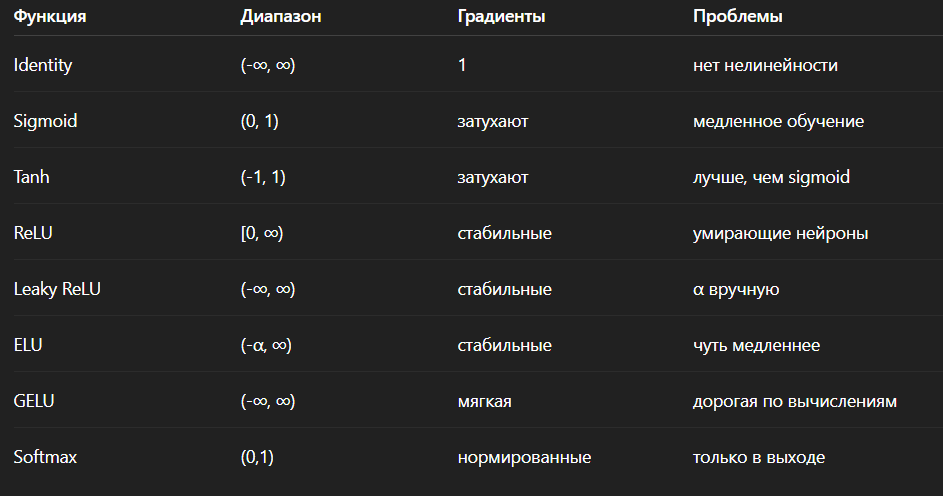

In [7]:
# Один слой: 3 входа -> 2 выхода
layer = nn.Linear(3, 2)
activation = nn.ReLU()  # активация

x = torch.tensor([[1.0, -2.0, -30.0]])  # вход
z = layer(x)   # линейное преобразование
a = activation(z)  # нелинейное преобразование

print("Линейный выход z:", z)
print("После ReLU a:", a)


Линейный выход z: tensor([[-15.2836,  12.8204]], grad_fn=<AddmmBackward0>)
После ReLU a: tensor([[ 0.0000, 12.8204]], grad_fn=<ReluBackward0>)


### 1) Identity (линейная функция)
$$
f(x) = x
$$
- Не добавляет нелинейности
- Непригодна для скрытых слоёв
- Используется:
    - В выходных слоях регрессионных моделей (например, при предсказании цены, температуры, координат).
    - Внутри сетей встречается крайне редко, потому что бесполезна как нелинейность.

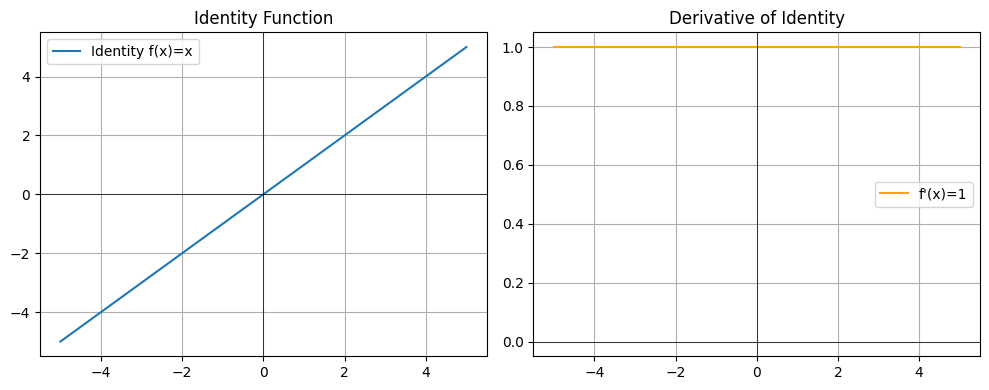

In [1]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 500)
y = x
dy = torch.ones_like(x)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x.numpy(), y.numpy(), label="Identity f(x)=x")
plt.title("Identity Function")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x.numpy(), dy.numpy(), label="f'(x)=1", color="orange")
plt.title("Derivative of Identity")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Identity()   # <-- можно явно прописать
        )

    def forward(self, x):
        return self.net(x)


### 2) Sigmoid
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
- это активационная функция, которая преобразует любое действительное число в диапазон (0,1).
- Сигмоида используется для:
    - Нормализации, значения всегда в диапазоне(0,1), что удобно для вероятностной интерпретации (например, классификация "да/нет").
- Производная сигмоиды выражается через саму функцию:
$$
\sigma'(x) = \sigma(x) \cdot (1 - \sigma(x))
$$

- Проблема исчезающего градиента: при больших по модулю 
𝑥
x градиент становится очень маленьким, обучение замедляется.

- Выход не центрирован вокруг нуля (может замедлять сходимость сети).

- Модели с глубокими слоями чаще используют ReLU или её варианты вместо сигмоиды.

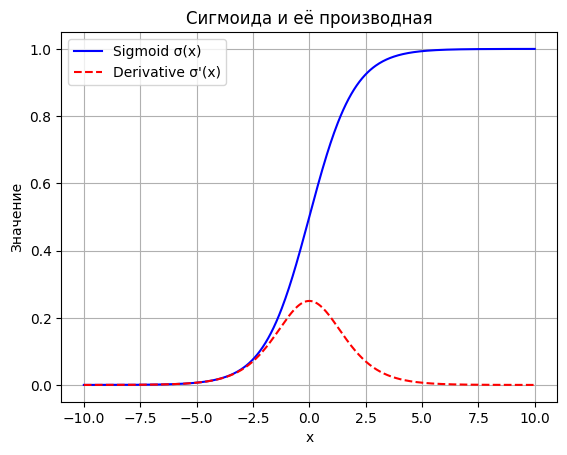

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

x = np.linspace(-10, 10, 500)

y = sigmoid(x)
y_derivative = sigmoid_derivative(x)

plt.plot(x, y, label="Sigmoid σ(x)", color='blue')
plt.plot(x, y_derivative, label="Derivative σ'(x)", color='red', linestyle='--')
plt.title("Сигмоида и её производная")
plt.xlabel("x")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
# Простая однослойная сеть для бинарной классификации
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.fc(x))

# Пример данных
X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = SimpleNN(input_size=2)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Обучение
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Выход сети после обучения:")
print(model(X).detach())


Выход сети после обучения:
tensor([[0.4997],
        [0.4998],
        [0.5002],
        [0.5002]])


### 3) Tanh
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$
- Это активационная функция, которая преобразует любое действительное число в диапазон (−1,1).
- Используется для Центрированности на нуле:
    - диапазон (−1,1) делает данные сбалансированными относительно нуля, что улучшает сходимость сети по сравнению с сигмоидой.
- Производная:
$$
\tanh'(x) = 1 - \tanh^2(x)
$$
- Используется в:
    - В скрытых слоях небольшой и средней глубины
    - В RNN, LSTM и GRU tanh часто применяется для активации скрытых состояний и вычисления новых значений памяти.

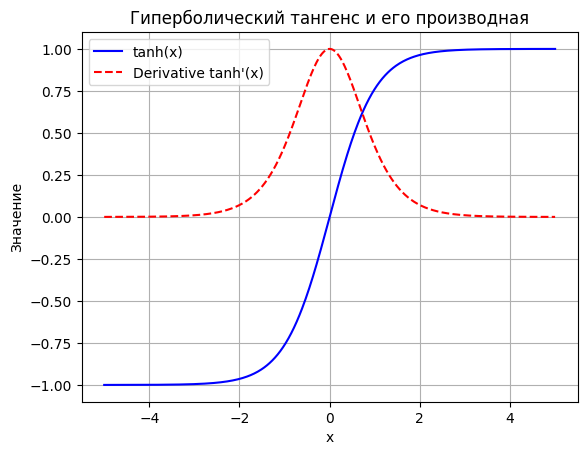

In [13]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

x = np.linspace(-5, 5, 500)
y = tanh(x)
y_derivative = tanh_derivative(x)

plt.plot(x, y, label="tanh(x)", color='blue')
plt.plot(x, y_derivative, label="Derivative tanh'(x)", color='red', linestyle='--')
plt.title("Гиперболический тангенс и его производная")
plt.xlabel("x")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = SimpleNN(input_size=2)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Выход сети после обучения:")
print(model(X).detach())


Выход сети после обучения:
tensor([[0.0186],
        [0.9306],
        [0.9421],
        [0.0892]])


### 4) ReLU (Rectified Linear Unit):
 
$$
\text{ReLU}(x) = \max(0, x)
$$
- ReLU используется для:

    - Нелинейности: позволяет сети моделировать сложные зависимости.

    - Ускорения обучения: вычисляется быстрее, чем сигмоида или tanh.

    - Сохранения градиентов для положительных значений: при 
    x>0 градиент равен 1, что уменьшает проблему исчезающего градиента.
- Производная ReLU:

$$
\text{ReLU}'(x) =
\begin{cases} 
1, & x > 0 \\ 
0, & x \le 0
\end{cases}
$$

- Для положительных \(x\) градиент равен 1 → обучение быстро распространяется.

- Минусы:

    - «Мёртвые нейроны»: если нейрон постоянно получает отрицательные входы, градиент равен 0 → нейрон больше не обновляется.

    - Не центрирована на нуле (выход ≥ 0), что иногда замедляет сходимость.

- Когда лучше использовать ReLU

    - Скрытые слои глубоких сетей

    - Когда нужно быстрое обучение и минимизация исчезающих градиентов

    - Для CNN и MLP, где часто ReLU заменяет сигмоиду или tanh

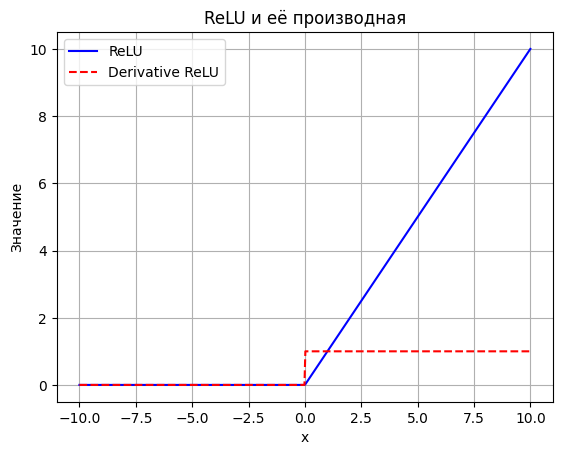

In [15]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

x = np.linspace(-10, 10, 500)
y = relu(x)
y_derivative = relu_derivative(x)

plt.plot(x, y, label="ReLU", color='blue')
plt.plot(x, y_derivative, label="Derivative ReLU", color='red', linestyle='--')
plt.title("ReLU и её производная")
plt.xlabel("x")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()


In [16]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()  
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = SimpleNN(input_size=2)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Выход сети после обучения:")
print(model(X).detach())


Выход сети после обучения:
tensor([[0.6613],
        [0.6613],
        [0.6613],
        [0.0143]])


### 5) Leaky ReLU
$$
\text{LeakyReLU}(x) = 
\begin{cases} 
x, & x \ge 0 \\ 
\alpha x, & x < 0 
\end{cases}
$$
где $\alpha$ — маленький положительный коэффициент(обычно 0.01).

- Leaky ReLU — это вариация ReLU, которая позволяет малому градиенту проходить для отрицательных значений.
- Производная Leaky ReLU:

$$
\text{LeakyReLU}'(x) =
\begin{cases} 
1, & x \ge 0 \\ 
\alpha, & x < 0 
\end{cases}
$$

- Для положительных \(x\) градиент = 1 (как у обычного ReLU)  
- Для отрицательных \(x\) градиент = \(\alpha\) → нейрон не «мертвый»
- Leaky ReLU лучше использовать вместо ReLU в следующих случаях:

    - Глубокие сети — чтобы избежать «мёртвых нейронов».

    - Входы с большим числом отрицательных значений — нейроны не блокируются полностью.

    - Рекуррентные сети (RNN, LSTM) — для стабильной передачи сигналов отрицательных значений.

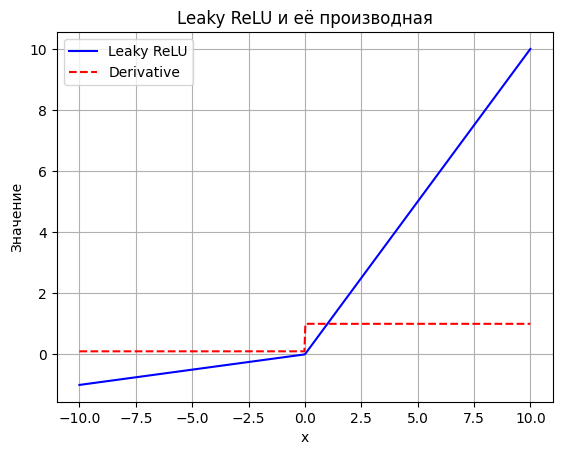

In [18]:
alpha = 0.1

def leaky_relu(x):
    return np.where(x >= 0, x, alpha * x)

def leaky_relu_derivative(x):
    return np.where(x >= 0, 1, alpha)

x = np.linspace(-10, 10, 500)
y = leaky_relu(x)
y_derivative = leaky_relu_derivative(x)

plt.plot(x, y, label="Leaky ReLU", color='blue')
plt.plot(x, y_derivative, label="Derivative", color='red', linestyle='--')
plt.title("Leaky ReLU и её производная")
plt.xlabel("x")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.lrelu = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()  # бинарная классификация
    
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = SimpleNN(input_size=2)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Выход сети после обучения:")
print(model(X).detach())


Выход сети после обучения:
tensor([[0.0178],
        [0.9723],
        [0.9680],
        [0.0202]])


### 6) ELU
$$
\text{ELU}(x) =
\begin{cases} 
x, & x \ge 0 \\ 
\alpha (e^x - 1), & x < 0
\end{cases}
$$

- это модификация ReLU, которая сохраняет положительные значения линейными, но для отрицательных значений использует экспоненциальную функцию.

- ELU решает несколько проблем ReLU и Leaky ReLU:
    - Для отрицательных значений функция принимает отрицательные значения ( −α,0) → среднее значение активаций ближе к нулю, ускоряя обучение.
    - Как Leaky ReLU, ELU не обнуляет градиент для отрицательных входов, но делает это плавно, с экспоненциальным затуханием.
- Производная ELU:

$$
\text{ELU}'(x) =
\begin{cases} 
1, & x \ge 0 \\ 
\alpha e^x, & x < 0
\end{cases}
$$

- Для положительных \(x\) градиент = 1 (как у ReLU)  
- Для отрицательных \(x\) градиент = \(\alpha e^x\) → небольшой, но ненулевой
- ELU лучше использовать, когда:

    - Нужно, чтобы активации были центрированы на нуле → ускоряет обучение.

    - В глубоких сетях, где важна плавная передача градиента для отрицательных значений.

    - Когда ReLU/Leaky ReLU дают резкие градиенты или мёртвые нейроны, а стабильность обучения критична.

    - Для глубоких MLP, RNN или CNN, где важна стабильность градиентов и скорость сходимости.

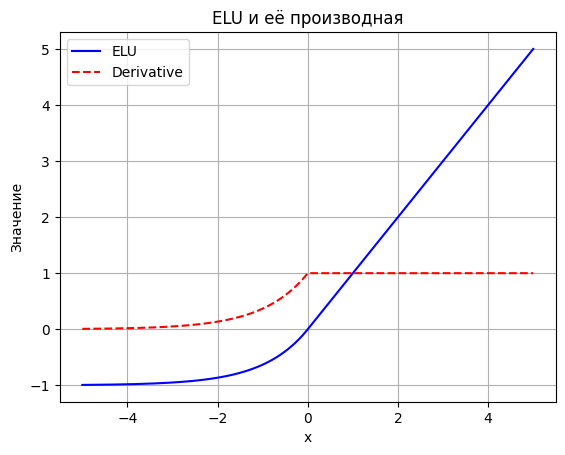

In [20]:
alpha = 1.0

def elu(x, alpha=alpha):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=alpha):
    return np.where(x >= 0, 1, alpha * np.exp(x))

x = np.linspace(-5, 5, 500)
y = elu(x)
y_derivative = elu_derivative(x)

plt.plot(x, y, label="ELU", color='blue')
plt.plot(x, y_derivative, label="Derivative", color='red', linestyle='--')
plt.title("ELU и её производная")
plt.xlabel("x")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()


In [32]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.elu = nn.ELU(alpha=1.0)
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()  # бинарная классификация
    
    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

X = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = SimpleNN(input_size=2)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Выход сети после обучения:")
print(model(X).detach())


Выход сети после обучения:
tensor([[0.0674],
        [0.8797],
        [0.8906],
        [0.1370]])


### 7) GELU
$$
\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2} \left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]
$$
- это современная активационная функция, популярная в трансформерах и BERT.
- Функция ошибки — это специальная математическая функция из теории вероятностей и статистики:

$$
\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^2} \, dt
$$

- Это интеграл от гауссовой (нормальной) функции \( e^{-t^2} \).

- Значения \( \text{erf}(x) \) всегда находятся в диапазоне \((-1, 1)\).

- Плюсы:

    - Плавный градиент → стабильное обучение

    - Центрированность около нуля

    - Лучшее поведение в глубоких сетях, особенно в трансформерах

- Минусы:

    - Более дорогая в вычислениях, чем ReLU

    - Реже используется в простых MLP или CNN

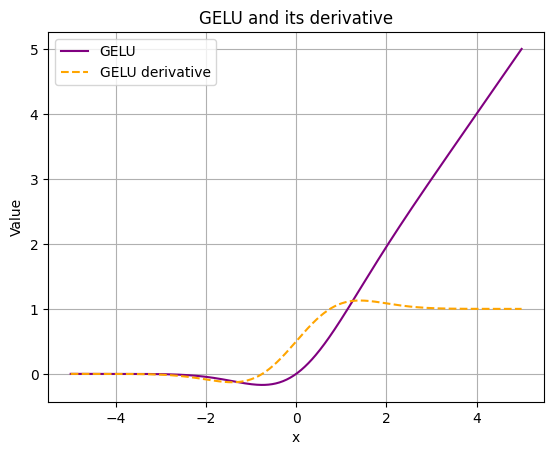

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

def gelu_derivative(x):
    return 0.5 * (1 + erf(x / np.sqrt(2))) + (x / np.sqrt(2*np.pi)) * np.exp(-x**2 / 2)

x = np.linspace(-5, 5, 500)
y = gelu(x)
y_derivative = gelu_derivative(x)

plt.plot(x, y, label="GELU", color='purple')
plt.plot(x, y_derivative, label="GELU derivative", color='orange', linestyle='--')
plt.title("GELU and its derivative")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn

class SimpleGELUNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(16, num_classes)
    
    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

X = torch.randn(4, 10)
model = SimpleGELUNN(input_size=10, num_classes=3)
output = model(X)
print(output)


tensor([[ 0.3075, -0.3020, -0.1668],
        [-0.1094, -0.2086, -0.4253],
        [-0.4723, -0.0612,  0.3266],
        [-0.2412, -0.2554,  0.2765]], grad_fn=<AddmmBackward0>)


### 8) Swish
## Swish (SiLU)

**Основная формула:**

$$
\text{Swish}(x) = x \cdot \sigma(x), \quad \sigma(x) = \frac{1}{1 + e^{-x}}
$$

 Здесь вход \(x\) умножается на его сигмоиду.  
- Для больших положительных \(x\) функция ведёт себя как \(x\).  
- Для больших отрицательных \(x\) значения плавно стремятся к 0 (но остаются чуть отрицательными).  
- В отличие от ReLU, Swish **плавная** и имеет ненулевой градиент даже для отрицательных входов.  

---

**Производная:**

$$
\frac{d}{dx}\,\text{Swish}(x) = \sigma(x) + x \cdot \sigma(x) \cdot \bigl(1 - \sigma(x)\bigr)
$$

 Она складывается из двух частей:  
1. \(\sigma(x)\) — вклад от самой сигмоиды.  
2. \(x \cdot \sigma(x) (1 - \sigma(x))\) — поправка, учитывающая, что сигмоида тоже зависит от \(x\).  

---

 Таким образом, Swish = плавная альтернатива ReLU, которая даёт:  
- меньше «мёртвых» нейронов,  
- более стабильные градиенты,  
- лучшее обучение в глубоких моделях (например, в трансформерах).


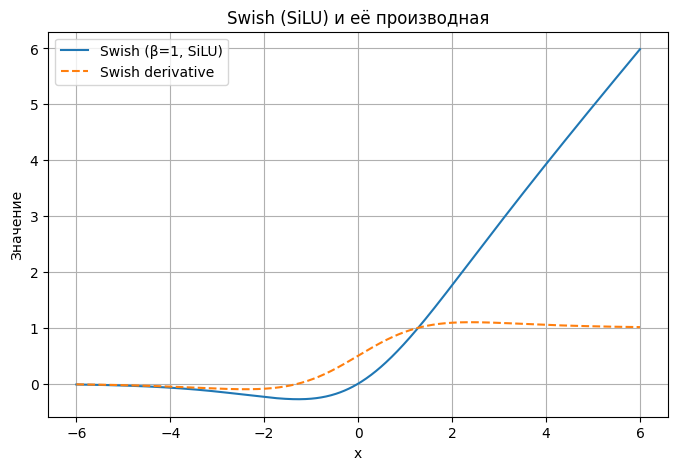

In [39]:
def sigmoid(u):
    return 1.0 / (1.0 + np.exp(-u))

def swish(x, beta=1.0):
    return x * sigmoid(beta * x)

def swish_derivative(x, beta=1.0):
    s = sigmoid(beta * x)
    return s * (1 + beta * x * (1 - s))

x = np.linspace(-6, 6, 800)
y  = swish(x, beta=1.0)
yd = swish_derivative(x, beta=1.0)

plt.figure(figsize=(8,5))
plt.plot(x, y,  label="Swish (β=1, SiLU)")
plt.plot(x, yd, label="Swish derivative", linestyle="--")
plt.title("Swish (SiLU) и её производная")
plt.xlabel("x")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()


In [40]:
import torch
import torch.nn as nn

class SwishNet(nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),               # Swish (β=1)
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Пример использования
model = SwishNet(in_dim=10, hidden=64, out_dim=3)
x = torch.randn(4, 10)
logits = model(x)
print(logits.shape)  # torch.Size([4, 3])


torch.Size([4, 3])


### 9) Softmax
$$
\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$
- это функция активации для выходного слоя нейросети, которая превращает вектор действительных чисел в вектор вероятностей, сумма которых равна 1.
- Softmax принимает вектор чисел и возвращает вектор вероятностей.

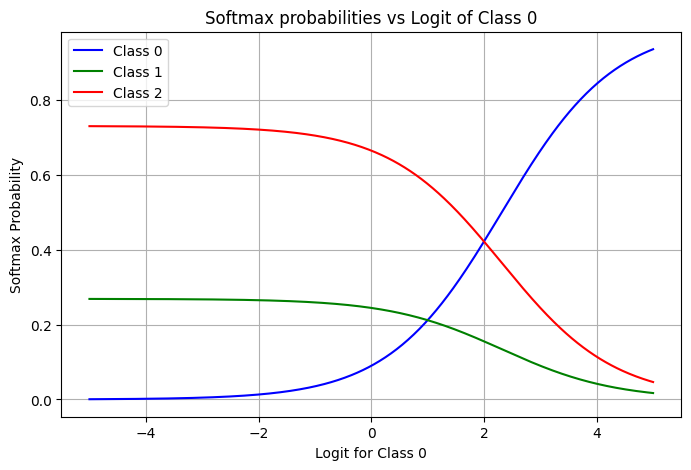

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x))  # стабилизация
    return e_x / e_x.sum()

# Фиксируем два логита и будем менять один
logit_fixed = [1.0, 2.0]  # класс 1 и класс 2 фиксированы
x0 = np.linspace(-5, 5, 500)  # изменяем логит класса 0

probs = np.array([softmax([x, logit_fixed[0], logit_fixed[1]]) for x in x0])

plt.figure(figsize=(8,5))
plt.plot(x0, probs[:,0], label='Class 0', color='blue')
plt.plot(x0, probs[:,1], label='Class 1', color='green')
plt.plot(x0, probs[:,2], label='Class 2', color='red')
plt.xlabel("Logit for Class 0")
plt.ylabel("Softmax Probability")
plt.title("Softmax probabilities vs Logit of Class 0")
plt.grid(True)
plt.legend()
plt.show()


In [34]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5, num_classes)
        self.softmax = nn.Softmax(dim=1)  # по классам
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

X = torch.tensor([[0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([0, 1, 2])  # классы

model = SimpleNN(input_size=2, num_classes=3)
criterion = nn.CrossEntropyLoss()  # учитывает softmax внутри
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

print("Выход сети после обучения (вероятности):")
print(model(X).detach())


Выход сети после обучения (вероятности):
tensor([[9.9243e-01, 2.1209e-05, 7.5459e-03],
        [9.8590e-05, 9.8893e-01, 1.0969e-02],
        [5.6731e-03, 6.1308e-03, 9.8820e-01]])
